In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report

In [2]:
# Load the MNIST dataset, and split it into a training set, a validation set, and a test set: 50,000instances for training, 10,000 for validation, and 10,000 for testing

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]
X = X.astype(np.float32)
y = y.astype(np.int64)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=10000, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                    y_train_full,
                                                    test_size=10000,
                                                    random_state=42)        

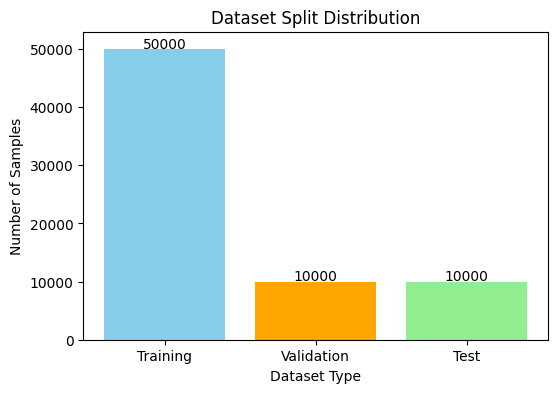

In [3]:
# Show a bar chart representing the number of samples in each dataset split (training, validation, test).

datasets = ['Training', 'Validation', 'Test']
counts = [len(X_train), len(X_valid), len(X_test)]

plt.figure(figsize=(6, 4))
plt.bar(datasets, counts, color=['skyblue', 'orange', 'lightgreen'])

plt.title('Dataset Split Distribution')
plt.xlabel('Dataset Type')
plt.ylabel('Number of Samples')

for i, count in enumerate(counts):
    plt.text(i, count + 200, str(count), ha='center', fontsize=10)

plt.ylim(0, max(counts) + 3000)
plt.show()

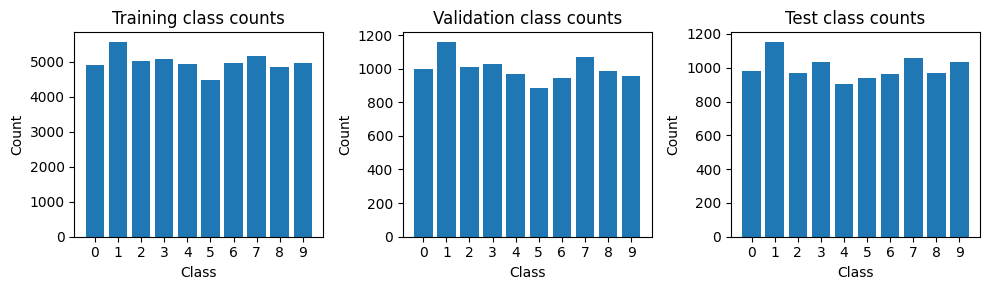

In [4]:
# Show a bar chart representing the number of instances for each digit (0 to 9) in each dataset split.

def plot_class_counts(y_splits, names):
    plt.figure(figsize=(10, 3))
    for i, (y_split, name) in enumerate(zip(y_splits, names), start=1):
        plt.subplot(1, 3, i)
        counts = np.bincount(y_split, minlength=10)
        plt.bar(range(10), counts)
        plt.title(f"{name} class counts")
        plt.xlabel("Class")
        plt.ylabel("Count")
        plt.xticks(range(10))
    plt.tight_layout()
    plt.show()

plot_class_counts(
    y_splits=[y_train, y_valid, y_test],
    names=["Training", "Validation", "Test"]
)

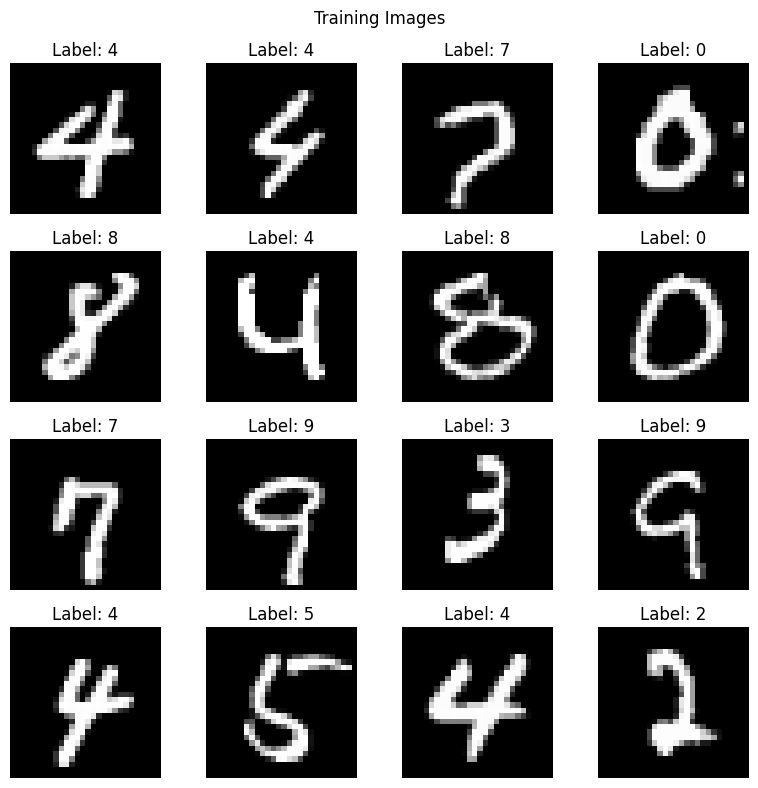

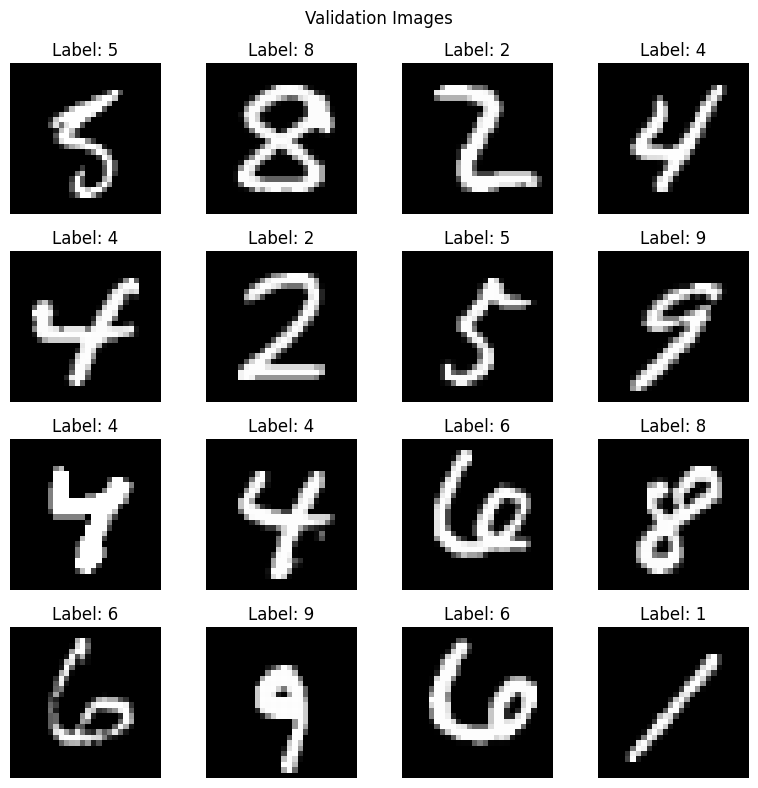

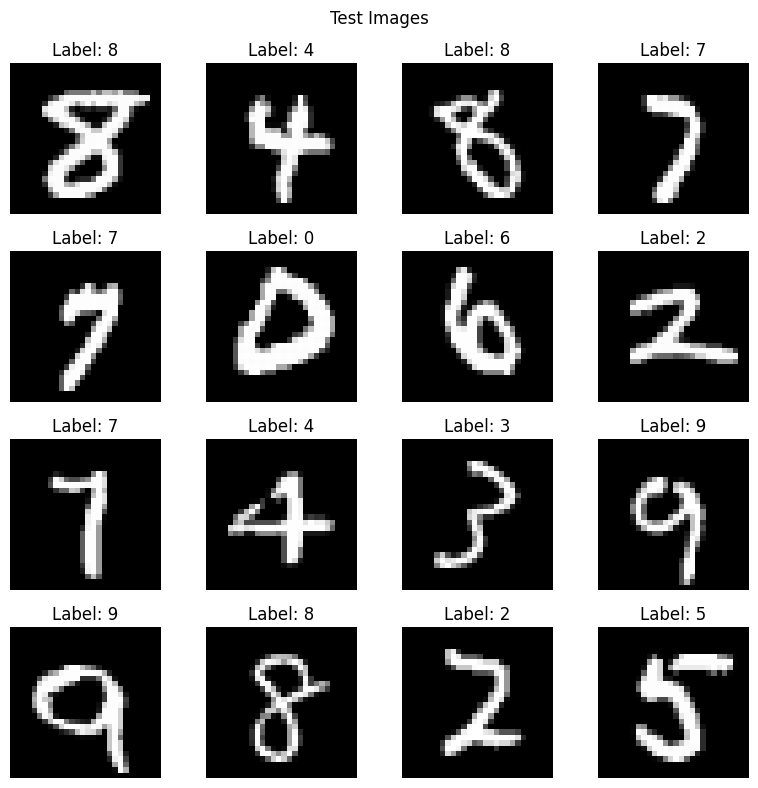

In [5]:
# visualize train val test images

def plot_sample_images(X, y, title):
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_sample_images(X_train, y_train, "Training Images")
plot_sample_images(X_valid, y_valid, "Validation Images")
plot_sample_images(X_test, y_test, "Test Images")


## 🌲 Random Forest Classifier — Mathematical Formulation

### 1. Dataset
Let the dataset be:
$$
\mathcal{D} = \{(x_i, y_i)\}_{i=1}^{n}, \quad x_i \in \mathbb{R}^d, \; y_i \in \{1, 2, \dots, K\}
$$

where  
- $\ x_i $ is the feature vector of the \( i^{th} \) sample,  
- $\ y_i $ is its class label,  
- $\ K $ is the total number of classes.

---

### 2. Bootstrap Sampling
Random Forest builds $ T $ decision trees.  
For each tree $t \in \{1, 2, \dots, T\}$,
a **bootstrap sample** $ \mathcal{D}_t $ is drawn **with replacement** from $ \mathcal{D}$:

$$
\mathcal{D}_t = \{(x_i, y_i)\}_{i=1}^{n_t}, \quad n_t = n
$$

---

### 3. Random Feature Selection
At each split node of tree $t $,  
a **random subset of features** $\mathcal{F}_t \subseteq \{1, 2, \dots, d\}$ is selected,  
where $|\mathcal{F}_t| = m \ll d$.
The best split is chosen based on a criterion (e.g., **Gini impurity** or **Entropy**).

**Gini Impurity:**
$$
G(S) = 1 - \sum_{k=1}^{K} p_k^2
$$

**Entropy:**
$$
H(S) = - \sum_{k=1}^{K} p_k \log(p_k)
$$

---

### 4. Individual Tree Prediction
Each decision tree \( h_t(x) \) outputs a predicted class label:
$$
h_t(x) = \arg\max_{k \in \{1, \dots, K\}} P_t(y = k \mid x)
$$

---

### 5. Ensemble Prediction (Majority Voting)
The Random Forest aggregates predictions from all \( T \) trees via **majority voting**:
$$
\hat{y} = \arg\max_{k \in \{1, \dots, K\}} \sum_{t=1}^{T} \mathbb{I}\left(h_t(x) = k\right)
$$

where $\mathbb{I}(\cdot)$ is the indicator function:

$$
\mathbb{I}(h_t(x) = k) =
\begin{cases}
1, & \text{if } h_t(x) = k \\
0, & \text{otherwise}
\end{cases}
$$

---

### 6. Optional — Probability Output
If probabilistic output is needed:
$$
P(y = k \mid x) = \frac{1}{T} \sum_{t=1}^{T} \mathbb{I}\left(h_t(x) = k\right)
$$

and the final prediction:
$$
\hat{y} = \arg\max_{k} P(y = k \mid x)
$$


In [6]:
# RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

rf_val_pred = rf.predict(X_valid)
rf_val_acc = accuracy_score(y_valid, rf_val_pred)
print(f"Validation accuracy(RandomForestClassifier): {rf_val_acc * 100:.2f}%")

Validation accuracy(RandomForestClassifier): 96.92%


In [7]:
rf_y_pred = rf.predict(X_test)
rf_y_pred

array([8, 4, 8, ..., 3, 8, 3], shape=(10000,))

In [8]:
# Calculate the accuracy of the predictions

X_trval = np.vstack([X_train, X_valid])
y_trval = np.hstack([y_train, y_valid])

rf_final = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_final.fit(X_trval, y_trval)

rf_test_pred = rf_final.predict(X_test)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

# Display the test accuracy
print(f"Test accuracy(RandomForestClassifier): {rf_test_acc * 100:.2f}%")

Test accuracy(RandomForestClassifier): 96.65%


## 🧮 Extra-Trees Classifier — Mathematical Formulation

Given a training dataset  

$$
D = \{(x_i, y_i)\}_{i=1}^N, \quad x_i \in \mathbb{R}^d, \, y_i \in \{1, 2, \dots, C\}
$$

the Extra-Trees (Extremely Randomized Trees) algorithm builds an ensemble of $T$ decision trees:

$$
\mathcal{H} = \{ h_t(x) \}_{t=1}^T
$$

---

### 1. Random Feature Subset

For each tree $t \in \{1, 2, \dots, T\}$,  
a random subset of features is selected:

$$
\mathcal{F}_t \subseteq \{1, 2, \dots, d\}, \quad |\mathcal{F}_t| = m \ll d
$$

---

### 2. Random Split at Each Node

At each internal node $n$ with data subset $D_n \subseteq D$:

- For each feature $f \in \mathcal{F}_t$, draw a random threshold  
  $\theta_f$ from a uniform distribution over the feature’s range:

$$
\theta_f \sim U\big(\min_{x_i \in D_n} x_{i,f}, \, \max_{x_i \in D_n} x_{i,f}\big)
$$

- For each candidate split $(f, \theta_f)$, compute the impurity (e.g., Gini impurity):

$$
G(D_n, f, \theta_f) = \frac{|D_{n,L}|}{|D_n|} \, H(D_{n,L}) + \frac{|D_{n,R}|}{|D_n|} \, H(D_{n,R})
$$

where  

$$
H(D) = 1 - \sum_{c=1}^{C} p_c^2, \quad p_c = \frac{1}{|D|} \sum_{(x_i, y_i) \in D} \mathbb{I}(y_i = c)
$$

and  

$$
D_{n,L} = \{(x_i, y_i) \in D_n : x_{i,f} \le \theta_f \}, \quad D_{n,R} = D_n \setminus D_{n,L}
$$

Select the feature–threshold pair that minimizes impurity:

$$
(f^*, \theta^*) = \arg\min_{f \in \mathcal{F}_t, \theta_f} G(D_n, f, \theta_f)
$$

---

### 3. Tree Growth

Continue recursively until:
- The node is pure, or  
- The number of samples $|D_n|$ is below a threshold $n_{\min}$.

Each tree grows fully, with no pruning.

---

### 4. Ensemble Prediction

For classification, the final prediction for a new sample $x$ is given by majority voting:

$$
\hat{y} = \arg\max_{c \in \{1, \dots, C\}} \sum_{t=1}^{T} \mathbb{I}\big( h_t(x) = c \big)
$$

where $\mathbb{I}(\cdot)$ is the indicator function.

---

### 5. Summary Equation

$$
\boxed{
\hat{y}(x) = \arg\max_{c} \sum_{t=1}^{T} \mathbb{I}\big(h_t(x) = c\big)
}
$$

subject to each $h_t$ being trained with random features $\mathcal{F}_t$  
and random thresholds $\theta_f \sim U(a_f, b_f)$.


In [9]:
# Extra-Trees classifier
et = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
et.fit(X_train, y_train)

et_val_pred = et.predict(X_valid)
et_val_acc = accuracy_score(y_valid, et_val_pred)
print(f"Validation accuracy (Extra-Trees): {et_val_acc * 100:.2f}%")

Validation accuracy (Extra-Trees): 97.15%


In [10]:
et_y_pred = et.predict(X_test)
et_y_pred

array([8, 4, 8, ..., 3, 8, 3], shape=(10000,))

In [11]:
et_final = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
et_final.fit(X_trval, y_trval)
et_test_pred = et_final.predict(X_test)
et_test_acc = accuracy_score(y_test, et_test_pred)
print(f"Test accuracy (Extra-Trees): {et_test_acc * 100:.2f}%")

Test accuracy (Extra-Trees): 96.82%


## Support Vector Machine (SVM) Classifier

For a labeled dataset  
$\mathcal{D} = \{(x_i, y_i)\}_{i=1}^N$,  
where $x_i \in \mathbb{R}^d$ and $y_i \in \{-1, +1\}$,  
the goal of SVM is to find a hyperplane that maximizes the margin between two classes.

---

### **1. Linear SVM (Hard Margin)**

We want to find parameters $(w, b)$ such that:

$$
y_i (w^\top x_i + b) \ge 1, \quad \forall i = 1, \dots, N
$$

The optimization problem is:

$$
\min_{w,b} \ \frac{1}{2} ||w||^2
$$

subject to

$$
y_i (w^\top x_i + b) \ge 1
$$

---

### **2. Soft Margin SVM**

To allow some misclassification, introduce slack variables $\xi_i \ge 0$:

$$
\min_{w,b,\xi} \ \frac{1}{2} ||w||^2 + C \sum_{i=1}^{N} \xi_i
$$

subject to

$$
y_i (w^\top x_i + b) \ge 1 - \xi_i, \quad \xi_i \ge 0
$$

where $C > 0$ controls the trade-off between margin width and classification error.

---

### **3. Dual Form (Kernelized SVM)**

Using Lagrange multipliers $\alpha_i$, we derive the dual optimization problem:

$$
\max_{\alpha} \ \sum_{i=1}^N \alpha_i - \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j y_i y_j K(x_i, x_j)
$$

subject to

$$
\sum_{i=1}^N \alpha_i y_i = 0, \quad 0 \le \alpha_i \le C
$$

where $K(x_i, x_j)$ is the kernel function, such as:

- Linear: $K(x_i, x_j) = x_i^\top x_j$
- Polynomial: $K(x_i, x_j) = (x_i^\top x_j + 1)^d$
- RBF: $K(x_i, x_j) = \exp(-\gamma ||x_i - x_j||^2)$

---

### **4. Decision Function**

Once $\alpha_i$ and $b$ are obtained, a new sample $x$ is classified as:

$$
f(x) = \text{sign} \left( \sum_{i=1}^N \alpha_i y_i K(x_i, x) + b \right)
$$


In [12]:
# SVM classifier

base_svm = make_pipeline(
    StandardScaler(with_mean=False),
    LinearSVC(random_state=42, dual=True)
)

base_svm.fit(X_train, y_train)

/home/infor/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,steps,"[('standardscaler', ...), ('linearsvc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,False
,with_std,True
,penalty,'l2'
,loss,'squared_hinge'
,dual,True
,tol,0.0001


In [13]:
calibrated_svm = CalibratedClassifierCV(base_svm, method='sigmoid', cv=3)
calibrated_svm.fit(X_trval, y_trval)

/home/infor/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/infor/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/infor/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,estimator,Pipeline(step...m_state=42))])
,method,'sigmoid'
,cv,3
,n_jobs,None
,ensemble,'auto'
,copy,True
,with_mean,False
,with_std,True
,penalty,'l2'
,loss,'squared_hinge'
,dual,True


In [14]:
svm_val_acc = accuracy_score(y_valid, calibrated_svm.predict(X_valid))
print(f"LinearSVM - Validation accuracy: {svm_val_acc * 100:.2f}%")

LinearSVM - Validation accuracy: 92.46%


In [15]:
X_trval = np.vstack([X_train, X_valid])
y_trval = np.hstack([y_train, y_valid])

calibrated_svm_final = make_pipeline(
    StandardScaler(with_mean=False),
    LinearSVC(random_state=42, dual=True)
)

calibrated_svm_final.fit(X_trval, y_trval)

svm_test_acc = accuracy_score(y_test, calibrated_svm_final.predict(X_test))
print(f"LinearSVM - Test accuracy: {svm_test_acc * 100:.2f}%")

LinearSVM - Test accuracy: 90.40%


/home/infor/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [16]:
# Voting Classifier

voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_final),
        ('et', et_final),
        ('svm', calibrated_svm)
    ],
    voting='soft',
    n_jobs=-1
)

voting_clf.fit(X_trval, y_trval)
voting_val_pred = voting_clf.predict(X_valid)
voting_val_acc = accuracy_score(y_valid, voting_val_pred)
print(f"Validation accuracy (VotingClassifier): {voting_val_acc * 100:.2f}%")
voting_test_pred = voting_clf.predict(X_test)
voting_test_acc = accuracy_score(y_test, voting_test_pred)
print(f"Test accuracy (VotingClassifier): {voting_test_acc * 100:.2f}%")


/home/infor/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/infor/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/infor/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation accuracy (VotingClassifier): 100.00%
Test accuracy (VotingClassifier): 95.86%


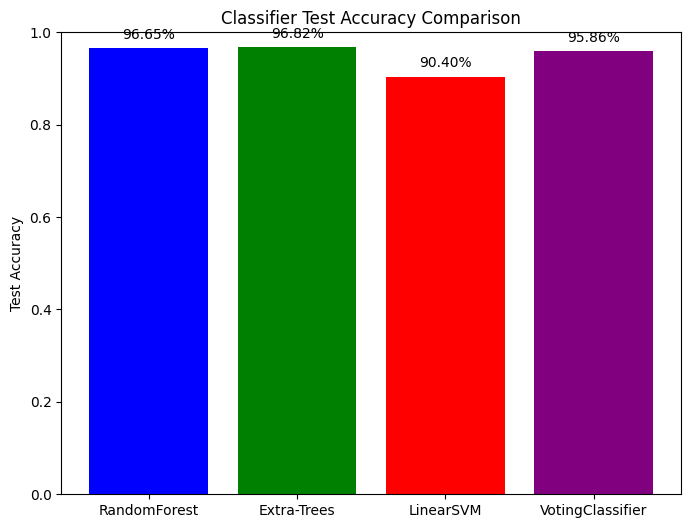

In [17]:
# plot the RandomForestClassifier, Extra-Trees classifier, and SVM classifier and voting classifier accuracy comparison bar chart

models = ['RandomForest', 'Extra-Trees', 'LinearSVM', 'VotingClassifier']
test_accuracies = [rf_test_acc, et_test_acc, svm_test_acc, voting_test_acc]
plt.figure(figsize=(8, 6))
plt.bar(models, test_accuracies, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.ylabel('Test Accuracy')
plt.title('Classifier Test Accuracy Comparison')
for i, acc in enumerate(test_accuracies):
    plt.text(i, acc + 0.02, f"{acc * 100:.2f}%", ha='center', fontsize=10)
plt.show()

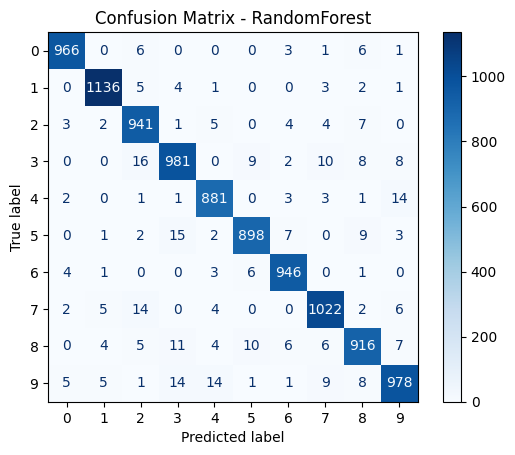

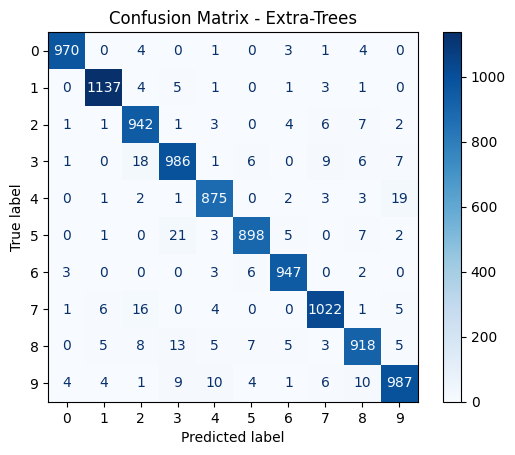

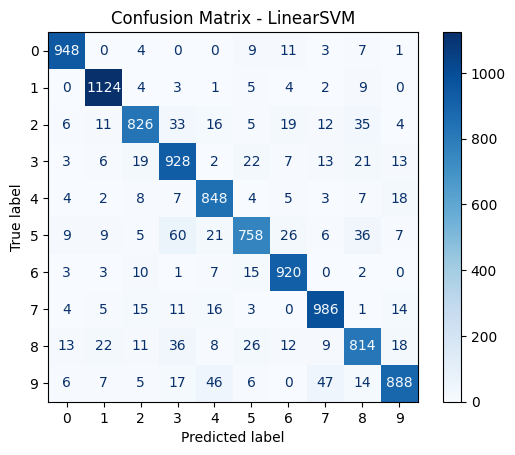

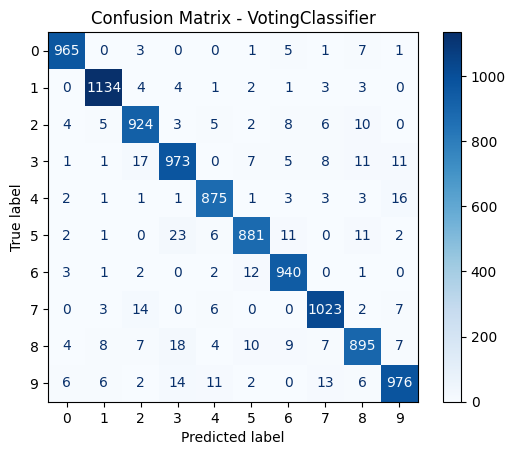

In [18]:
# Show each classifier's confusion matrix on the test set

for model, name in zip([rf_final, et_final, calibrated_svm_final, voting_clf],
                       ['RandomForest', 'Extra-Trees', 'LinearSVM', 'VotingClassifier']):
    y_pred = model.predict(X_test)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
    disp.ax_.set_title(f'Confusion Matrix - {name}')
    plt.show()


In [19]:
# Show other results such as precision, recall, and F1-score for each classifier on the test set.

for model, name in zip([rf_final, et_final, calibrated_svm_final, voting_clf],
                       ['RandomForest', 'Extra-Trees', 'LinearSVM', 'VotingClassifier']):
    y_pred = model.predict(X_test)
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))

Classification Report for RandomForest:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       983
           1       0.98      0.99      0.99      1152
           2       0.95      0.97      0.96       967
           3       0.96      0.95      0.95      1034
           4       0.96      0.97      0.97       906
           5       0.97      0.96      0.97       937
           6       0.97      0.98      0.98       961
           7       0.97      0.97      0.97      1055
           8       0.95      0.95      0.95       969
           9       0.96      0.94      0.95      1036

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Classification Report for Extra-Trees:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       983
           1       0.98      0.99      0.99      11

# 🐦 Particle Swarm Optimization (PSO)

How to improve the model performance further? using Particle Swarm Optimization (PSO), the algorithm is a **population-based stochastic optimization algorithm** inspired by **bird flocking** and **fish schooling**.  
It was first proposed by **Kennedy and Eberhart (1995)** and has since become a fundamental technique in **swarm intelligence**.

Each candidate solution, called a **particle**, represents a point in the search space.  
Particles move according to both their **personal experience** and the **global best** discovered by the swarm.

---

## 🧮 Mathematical Formulation

### 1. Initialization

At iteration \( t = 0 \):

- There are $ N $ particles.  
- Each particle $ i $ has:
  - Position vector $\ \mathbf{x}_i(t) \in \mathbb{R}^D$
  - Velocity vector $\ \mathbf{v}_i(t) \in \mathbb{R}^D$
  - Personal best position $ \mathbf{p}_i$

The global best position among all particles is:

$$
\mathbf{g} = \arg\min_{\mathbf{x}_i} f(\mathbf{x}_i)
$$

---

### 2. Velocity Update

For each particle \( i \) and each dimension \( d \):

$$
v_{i,d}(t+1) = \omega v_{i,d}(t)
+ c_1 r_1 \big(p_{i,d} - x_{i,d}(t)\big)
+ c_2 r_2 \big(g_d - x_{i,d}(t)\big)
$$

where:  
- $\omega$: inertia weight  
- $c_1, c_2$: acceleration coefficients for cognitive and social components  
- $r_1, r_2 \sim U(0,1)$: random numbers uniformly distributed in $[0,1]$

---

### 3. Position Update

$$
x_{i,d}(t+1) = x_{i,d}(t) + v_{i,d}(t+1)
$$

---

### 4. Personal and Global Best Updates

$$
\mathbf{p}_i =
\begin{cases}
\mathbf{x}_i(t+1), & \text{if } f(\mathbf{x}_i(t+1)) < f(\mathbf{p}_i) \\
\mathbf{p}_i, & \text{otherwise}
\end{cases}
$$

$$
\mathbf{g} = \arg\min_{\mathbf{p}_i} f(\mathbf{p}_i)
$$


---

### 5. Termination Condition

Repeat the update process until one of the following is satisfied:

$$
| f(\mathbf{g}(t+1)) - f(\mathbf{g}(t)) | < \varepsilon
$$
or
$$
t \geq t_{\max}
$$

In [20]:
# How to improve the model performance further? using Particle Swarm Optimization (PSO)

def fitness_function(params):
    n_estimators, max_depth = params
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    val_pred = model.predict(X_valid)
    val_acc = accuracy_score(y_valid, val_pred)
    
    return 1 - val_acc  # Minimize the error

def pso_optimize(fitness_func, bounds, num_particles=10, max_iter=20):
    dim = len(bounds)
    particles = np.random.rand(num_particles, dim)
    for i in range(dim):
        particles[:, i] = bounds[i][0] + particles[:, i] * (bounds[i][1] - bounds[i][0])
    
    velocities = np.random.rand(num_particles, dim) * 0.1
    personal_best_positions = particles.copy()
    personal_best_scores = np.array([fitness_func(p) for p in particles])
    global_best_position = personal_best_positions[np.argmin(personal_best_scores)]
    
    for iteration in range(max_iter):
        for i in range(num_particles):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[i] = (0.5 * velocities[i] +
                             1.5 * r1 * (personal_best_positions[i] - particles[i]) +
                             1.5 * r2 * (global_best_position - particles[i]))
            particles[i] += velocities[i]
            for d in range(dim):
                particles[i, d] = np.clip(particles[i, d], bounds[d][0], bounds[d][1])
            
            score = fitness_func(particles[i])
            if score < personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best_positions[i] = particles[i]
        
        global_best_position = personal_best_positions[np.argmin(personal_best_scores)]
        print(f"Iteration {iteration + 1}/{max_iter}, Best Score: {1 - min(personal_best_scores):.4f}")
    
    return global_best_position

In [21]:
bounds = [(10, 200), (5, 50)]  # n_estimators, max_depth
best_params = pso_optimize(fitness_function, bounds)
best_n_estimators, best_max_depth = map(int, best_params)
print(f"Optimized Parameters - n_estimators: {best_n_estimators}, max_depth: {best_max_depth}")

optimized_rf = RandomForestClassifier(n_estimators=best_n_estimators,
                                      max_depth=best_max_depth,
                                      random_state=42,
                                      n_jobs=-1)
optimized_rf.fit(X_trval, y_trval)
optimized_rf_test_pred = optimized_rf.predict(X_test)
optimized_rf_test_acc = accuracy_score(y_test, optimized_rf_test_pred)
print(f"Test accuracy (Optimized RandomForest): {optimized_rf_test_acc * 100:.2f}%")

Iteration 1/20, Best Score: 0.9709
Iteration 2/20, Best Score: 0.9709
Iteration 3/20, Best Score: 0.9709
Iteration 4/20, Best Score: 0.9709
Iteration 5/20, Best Score: 0.9709
Iteration 6/20, Best Score: 0.9709
Iteration 7/20, Best Score: 0.9709
Iteration 8/20, Best Score: 0.9709
Iteration 9/20, Best Score: 0.9709
Iteration 10/20, Best Score: 0.9709
Iteration 11/20, Best Score: 0.9709
Iteration 12/20, Best Score: 0.9709
Iteration 13/20, Best Score: 0.9709
Iteration 14/20, Best Score: 0.9709
Iteration 15/20, Best Score: 0.9709
Iteration 16/20, Best Score: 0.9709
Iteration 17/20, Best Score: 0.9709
Iteration 18/20, Best Score: 0.9709
Iteration 19/20, Best Score: 0.9709
Iteration 20/20, Best Score: 0.9709
Optimized Parameters - n_estimators: 130, max_depth: 18
Test accuracy (Optimized RandomForest): 96.70%


In [22]:
# optimize Extra-Trees classifier

bounds_et = [(10, 200), (5, 50)]  # n_estimators, max_depth
best_params_et = pso_optimize(fitness_function, bounds_et)
best_n_estimators_et, best_max_depth_et = map(int, best_params_et)
print(f"Optimized Parameters - n_estimators: {best_n_estimators_et}, max_depth: {best_max_depth_et}")

optimized_et = ExtraTreesClassifier(n_estimators=best_n_estimators_et,
                                   max_depth=best_max_depth_et,
                                   random_state=42,
                                   n_jobs=-1)
optimized_et.fit(X_trval, y_trval)
optimized_et_test_pred = optimized_et.predict(X_test)
optimized_et_test_acc = accuracy_score(y_test, optimized_et_test_pred)
print(f"Test accuracy (Optimized Extra-Trees): {optimized_et_test_acc * 100:.2f}%")

Iteration 1/20, Best Score: 0.9708
Iteration 2/20, Best Score: 0.9708
Iteration 3/20, Best Score: 0.9708
Iteration 4/20, Best Score: 0.9708
Iteration 5/20, Best Score: 0.9712
Iteration 6/20, Best Score: 0.9717
Iteration 7/20, Best Score: 0.9717
Iteration 8/20, Best Score: 0.9717
Iteration 9/20, Best Score: 0.9717
Iteration 10/20, Best Score: 0.9717
Iteration 11/20, Best Score: 0.9717
Iteration 12/20, Best Score: 0.9717
Iteration 13/20, Best Score: 0.9717
Iteration 14/20, Best Score: 0.9717
Iteration 15/20, Best Score: 0.9717
Iteration 16/20, Best Score: 0.9717
Iteration 17/20, Best Score: 0.9717
Iteration 18/20, Best Score: 0.9717
Iteration 19/20, Best Score: 0.9717
Iteration 20/20, Best Score: 0.9717
Optimized Parameters - n_estimators: 177, max_depth: 25
Test accuracy (Optimized Extra-Trees): 97.03%


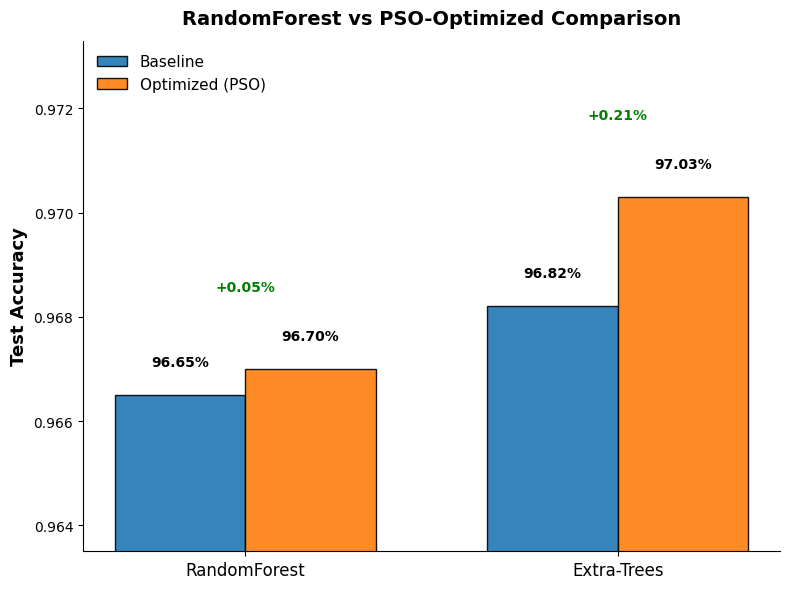

In [23]:
# Show optimized classifiers test accuracy comparison bar chart, comparing with previous results.

groups = ['RandomForest', 'Extra-Trees']

baseline_acc = [rf_test_acc, et_test_acc]
optimized_acc = [optimized_rf_test_acc, optimized_et_test_acc]

x = np.arange(len(groups))
width = 0.35

plt.figure(figsize=(8, 6))

bars1 = plt.bar(
    x - width/2, baseline_acc, width,
    label='Baseline',
    color='#1f77b4',
    edgecolor='black',
    alpha=0.9
)
bars2 = plt.bar(
    x + width/2, optimized_acc, width,
    label='Optimized (PSO)',
    color='#ff7f0e',
    edgecolor='black',
    alpha=0.9
)

plt.ylabel('Test Accuracy', fontsize=13, fontweight='bold')
plt.title('RandomForest vs PSO-Optimized Comparison',
          fontsize=14, fontweight='bold', pad=12)
plt.xticks(x, groups, fontsize=12)

y_min = min(baseline_acc + optimized_acc) - 0.003
y_max = max(baseline_acc + optimized_acc) + 0.003
plt.ylim(y_min, y_max)

plt.legend(fontsize=11, loc='upper left', frameon=False)

for bars, accs in zip([bars1, bars2], [baseline_acc, optimized_acc]):
    for bar, acc in zip(bars, accs):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.0005,
            f"{acc * 100:.2f}%",
            ha='center', va='bottom',
            fontsize=10, fontweight='bold'
        )

for i in range(len(groups)):
    delta = (optimized_acc[i] - baseline_acc[i]) * 100
    top = max(baseline_acc[i], optimized_acc[i])
    plt.text(
        x[i],
        top + 0.0015,
        f"+{delta:.2f}%",
        ha='center',
        fontsize=10,
        color='green',
        fontweight='bold'
    )

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


## References

[Load MNIST Dataset][https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html]

[Particle swarm optimization]: Kennedy, J., & Eberhart, R. (1995, November). *Particle swarm optimization*. In *Proceedings of ICNN'95-International Conference on Neural Networks* (Vol. 4, pp. 1942–1948). IEEE.